In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [ ]:
CAR_DATASET_PATH = "/car_price.csv"
car_df = pd.read_csv(CAR_DATASET_PATH)
car_df.head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
6,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,17.3 km/kg,1061 CC,57.5 bhp,"7.8@ 4,500(kgm@ rpm)",5.0
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,16.1 kmpl,796 CC,37 bhp,59Nm@ 2500rpm,4.0
8,Toyota Etios VXD,2011,350000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.1 bhp,170Nm@ 1800-2400rpm,5.0
9,Ford Figo Diesel Celebration Edition,2013,200000,169000,Diesel,Individual,Manual,First Owner,20.0 kmpl,1399 CC,68.1 bhp,160Nm@ 2000rpm,5.0


In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [ ]:
car_df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [ ]:
car_df.describe(include=["O"])

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,8128,8128,8128,8128,8128,7907,7907,7913,7906
unique,2058,4,3,2,5,393,121,322,441
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,129,4402,6766,7078,5289,225,1017,377,530


Some things we need to take care about:
- Take care of the categorical data -> convert to numericals
- Some values such as engine and mileage are strings but can be coverted to float / int 
- Look at the values and remove those with weak correlation
- remove torque
- split into train and test set
- build and test the model

In [ ]:
def cleaning_up_the_data(car_df):
    #converting max power to only floating point values
    def clean_max_power(x):
        if isinstance(x, str):
            temp = x.split()
            if len(temp) >= 2:
                return temp[0]
            else:
                return None
        return x

    car_df["max_power"] = car_df["max_power"].apply(clean_max_power).astype("float")

    #converting mileage from string to floating point values
    def clean_mileage(x):
        if isinstance(x, str):
            temp = x.split()
            if len(temp) >= 2:
                return temp[0]
            else:
                return None
        return x

    car_df["mileage"] = car_df["mileage"].apply(clean_mileage).astype("float")

    #converting engine from string to int
    def clean_engine(x):
        if isinstance(x, str):
            temp = x.split()
            if len(temp) >= 2:
                return temp[0]
            else:
                return None
        return x

    car_df["engine"] = car_df["engine"].apply(clean_engine).astype("float")

    #removing torque
    car_df.pop("torque")

    # getting only the brand name (first word in car name)
    def clean_car_name(x):
        if isinstance(x, str):
            temp = x.split()
            if len(temp) > 0:
                return temp[0].upper()
            else:
                return None
        return x

    car_df["name"] = car_df["name"].apply(clean_car_name)

    #dropping seats
    # car_df.pop("seats")

    # #dropping mileage
    # car_df.pop("mileage")

    #dropping null vals
    car_df.dropna(how="any", inplace=True)

    # converting fuel to a numerical value
    fuel_types = {'Diesel':0, 'Petrol':1, 'LPG':2, 'CNG':3}
    car_df["fuel"].replace(to_replace=fuel_types, inplace=True)

    # converting seller type to a numerical value
    seller_types = {'Individual':0, 'Dealer':1, 'Trustmark Dealer':2}
    car_df["seller_type"].replace(to_replace=seller_types, inplace=True)

    # converting transmission type to numerical value
    transmission_types = {"Manual":0, "Automatic":1}
    car_df["transmission"].replace(to_replace=transmission_types, inplace=True)

    #owner to numerical value
    owners = car_df["owner"].unique()
    owners_types = {}
    num =0

    for x in owners:
        if x not in owners_types:
            owners_types[x] = num
            num += 1

    car_df["owner"].replace(to_replace=owners_types, inplace=True)

    # removing test driven cars as it only appears 5 times
    car_df.drop(car_df.loc[car_df["owner"] == 4].index, inplace=True)

    #car names value encoding
    carNames = car_df["name"].unique()
    carNames_dict = {}
    num = 0

    for x in carNames:
        if x not in carNames_dict:
            carNames_dict[x] = num
            num += 1

    car_df["name"].replace(to_replace=carNames_dict, inplace=True)

In [ ]:
cleaning_up_the_data(car_df)

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7901 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           7901 non-null   int64  
 1   year           7901 non-null   int64  
 2   selling_price  7901 non-null   int64  
 3   km_driven      7901 non-null   int64  
 4   fuel           7901 non-null   int64  
 5   seller_type    7901 non-null   int64  
 6   transmission   7901 non-null   int64  
 7   owner          7901 non-null   int64  
 8   mileage        7901 non-null   float64
 9   engine         7901 non-null   float64
 10  max_power      7901 non-null   float64
 11  seats          7901 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 802.4 KB


In [ ]:
car_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,0,2014,450000,145500,0,0,0,0,23.40,1248.0,74.00,5.0
1,1,2014,370000,120000,0,0,0,1,21.14,1498.0,103.52,5.0
2,2,2006,158000,140000,1,0,0,2,17.70,1497.0,78.00,5.0
3,3,2010,225000,127000,0,0,0,0,23.00,1396.0,90.00,5.0
4,0,2007,130000,120000,1,0,0,0,16.10,1298.0,88.20,5.0


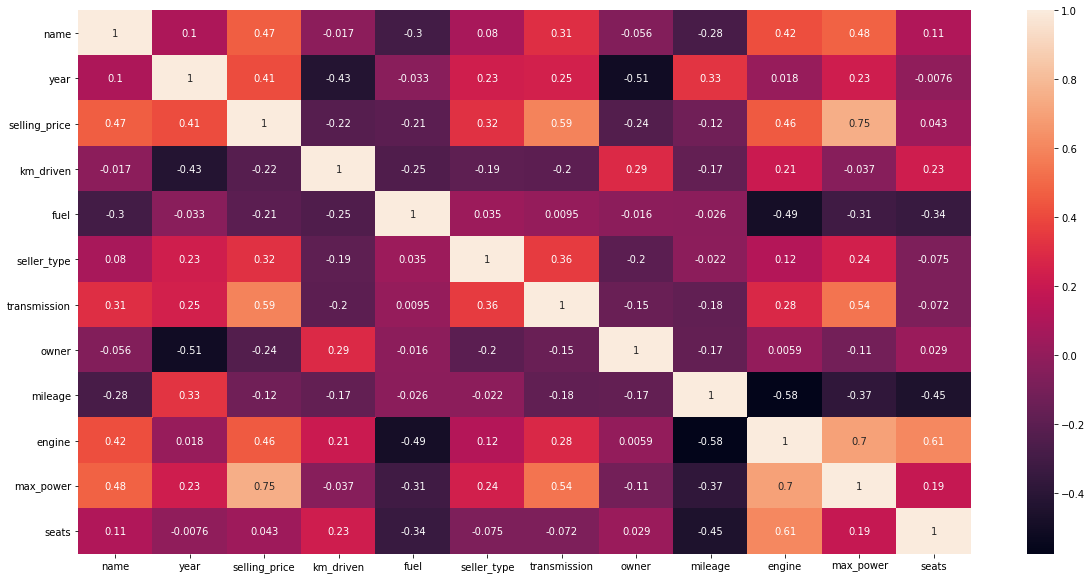

In [ ]:
corrMatrix = car_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17de524908>,
      dtype=object)

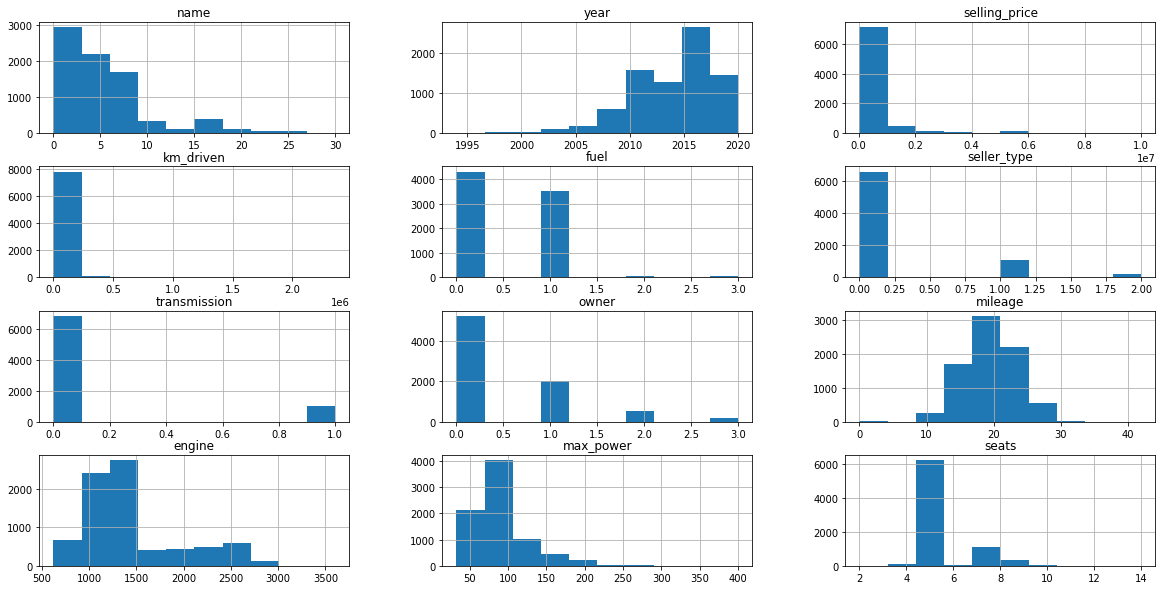

In [ ]:
car_df.hist()

'\nyear    km_driven   fuel\nengine  max_power   seller_type\nowner   name        seats\nmileage N/A         N/A\n'

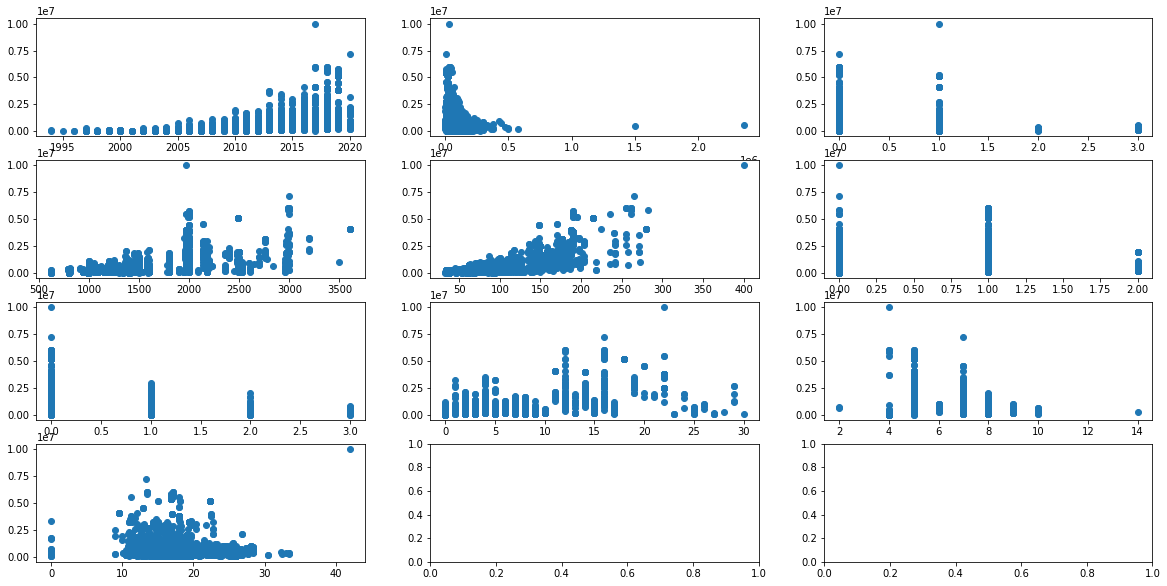

<Figure size 3600x3600 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(4,3)

ax[0,0].scatter([car_df["year"]], car_df["selling_price"])
ax[0,1].scatter([car_df["km_driven"]], car_df["selling_price"])
ax[0,2].scatter([car_df["fuel"]], car_df["selling_price"])
ax[1,0].scatter([car_df["engine"]], car_df["selling_price"])
ax[1,1].scatter([car_df["max_power"]], car_df["selling_price"])
ax[1,2].scatter([car_df["seller_type"]], car_df["selling_price"])
ax[2,0].scatter([car_df["owner"]], car_df["selling_price"])
ax[2,1].scatter([car_df["name"]], car_df["selling_price"])
ax[2,2].scatter([car_df["seats"]], car_df["selling_price"])
ax[3,0].scatter([car_df["mileage"]], car_df["selling_price"])

plt.figure(figsize=(50,50))
fig.show()
"""
year    km_driven   fuel
engine  max_power   seller_type
owner   name        seats
mileage N/A         N/A
"""

In [ ]:
# splitting into test and trainign sets
def train_test_split(X):
    X = X.sample(frac=1)
    TRAIN_SIZE = int(0.8 * len(X))
    train, test = X.iloc[:TRAIN_SIZE, :], X.iloc[TRAIN_SIZE:, :]

    train_y, test_y = train.pop("selling_price"), test.pop("selling_price")

    return (train.to_numpy(), test.to_numpy(), train_y.to_numpy(), test_y.to_numpy())

x_train, x_test, y_train, y_test = train_test_split(car_df)

# Linear reg from scratch
### Basic steps:
1. Intialising random vals for coeffecients and slope of 0 in the beginning
2. forward propogation -> Generating predictions
3. Calculating cost
4. back propogation -> getting the gradients (slope, coeffs)
5. updating the slope and coeffecient vallues
6. repeating steps 2 - 6 for our desired number of epochs.

In [ ]:
#BUILD CLASS TO FIND LINEAR REG
class MyLinearReg:
    def __init__(self):
        self.coefs = np.random.randn(1, len(x_train[0])) # random vals for each parameter coeff
        self.slope = 0 # slope starts at 0

    def forward_prop(self, X):
        # matrix multiplication between coeffs and X
        # X.shape = n * m   coefs.shape = 1 * n     z.shape = 1 * m
        z = np.dot(self.coefs, X) + self.slope
        # adding the bias AKA slope
        # z --> predicted vals
        return z
    
    def cost_func(self, z, y):
        # z-> predicted y-> truth
        m = len(y) # m vals (number of vals)
        J = (1/(2 * m)) * np.sum(np.square(z - y)) # getting squared errors
        # multiplying by reciprocal of 2m for cost func
        return J

    def back_prop(self, X, y, z):
        m = len(y) # m vals (number of vals)
        d_coeffs =  - 2 / m * np.sum(2 * (y - z) * X) #gradient of coeffs
        d_slope = - 2 / m * np.sum(2 * (y - z)) #gradient of slopee
        return d_coeffs, d_slope
    
    def gradient_descent_update(self, d_coeffs, d_slope, lr):
        #updating gradients
        self.coefs = self.coefs - (lr * d_coeffs)
        self.slope = self.slope - (lr * d_slope)
    
    def normalise_vals(self, arr):
        arr = arr - arr.mean(axis=0)
        arr = arr / np.abs(arr).max(axis=0)
        return arr

    def fit(self, x_train, y_train, x_test, y_test, lr, epochs):
        """
        given X and y fitting a linear reg
        """
        # noromalising values
        x_train = self.normalise_vals(x_train)
        x_test = self.normalise_vals(x_test)
        cost_train_vals = []
        m_train = len(y_train)
        m_val = len(y_test)

        for epoch in range(1, epochs + 1):
            z_train = self.forward_prop(x_train)
            cost_train = self.cost_func(z_train, y_train)
            dw, db = self.back_prop(x_train, y_train, z_train)
            self.gradient_descent_update(dw, db, lr)

            # store every 10th value to graph
            # if epoch % 10 == 0:
            cost_train_vals.append(cost_train)

            #Mean absolute error MAE
            MAE_train = (1 / m_train) * np.sum(np.abs(z_train - y_train))

            #validation set
            z_val = self.forward_prop(x_test)
            cost_val = self.cost_func(z_val, y_test)
            MAE_val = (1 / m_val) * np.sum(np.abs(z_val - y_test))

            #prinitng out
            print(f"EPOCHS {epoch} / {epochs} training MAE {MAE_train} validation MAE {MAE_val} training cost {cost_train} validation cost {cost_val}")
        
        plt.scatter([x for x in range(len(cost_train_vals))], cost_train_vals)
        return (self.slope, self.coefs)
    
    def R2_val (self, X, y):
        # variation across line
        m = len(y)
        z = (np.dot(self.coefs, X.T) + self.slope)
        res = (y - z)
        ss = np.sum(res**2)
        ss /= m
        # print(ss)
        # variation across mean
        mean = np.mean(y)
        var_mean = np.sum((y - mean) ** 2)
        # print(var_mean)
        var_mean /= m 
        print(f"var across line {ss} || var across mean {var_mean}")
        return ((var_mean - ss) / var_mean) * 100


EPOCHS 1 / 50 training MAE 641273.5143770612 validation MAE 2027643.0070007192 training cost 518718529749.81647 validation cost 2164268533517.6357
EPOCHS 2 / 50 training MAE 2034557.9318914698 validation MAE 5802270.868517928 training cost 2163645410715.8438 validation cost 17205696250794.758
EPOCHS 3 / 50 training MAE 5771461.62939355 validation MAE 17283575.649056267 training cost 16967987339410.086 validation cost 149733516243294.28
EPOCHS 4 / 50 training MAE 17314384.888180647 validation MAE 51973963.903666325 training cost 150207064697658.25 validation cost 1351018984564773.5
EPOCHS 5 / 50 training MAE 51943154.66454194 validation MAE 155798654.75450143 training cost 1349358760921891.8 validation cost 1.2136982934291136e+16
EPOCHS 6 / 50 training MAE 155829463.99362582 validation MAE 467519201.2200019 training cost 1.2141724026939994e+16 validation cost 1.0928747427732925e+17
EPOCHS 7 / 50 training MAE 467488391.98087746 validation MAE 1402434366.703508 training cost 1.09273011421

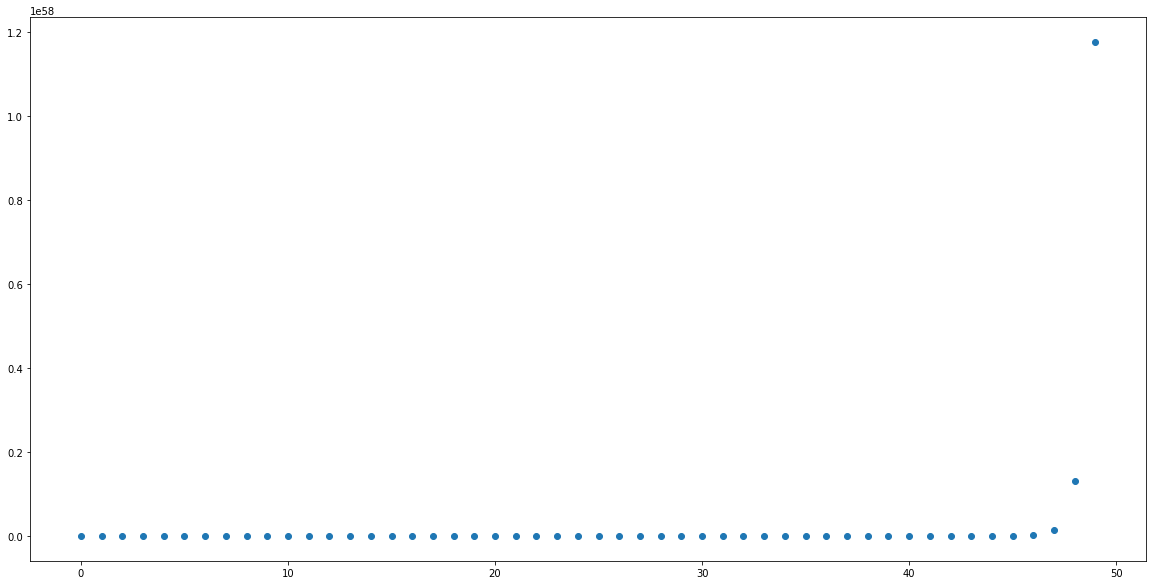

In [ ]:
 linearReg = MyLinearReg()
slope, coeff = linearReg.fit(x_train.T, y_train, x_test.T, y_test, 1, 50)

In [ ]:
slope, coeff

(-4.6036896553137464e+29,
 array([[1.27095891e+14, 1.27095891e+14, 1.27095891e+14, 1.27095891e+14,
         1.27095891e+14, 1.27095891e+14, 1.27095891e+14, 1.27095891e+14,
         1.27095891e+14, 1.27095891e+14, 1.27095891e+14]]))

In [ ]:
r2 = linearReg.R2_val(x_test, y_test)
print("-"*20)
print(r2)

var across line 2.119395844159515e+59 || var across mean 745045161999.5598
--------------------
-2.844654193138385e+49


# Linear reg using Scikit learn (for comparision)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x_train, y_train)

In [ ]:
print(f"{model.intercept_}\n{model.coef_}")

-60098165.51563468
[ 2.16111826e+04  2.93663958e+04 -9.04360690e-01 -3.78986773e+03
  9.69896783e+04  4.50224457e+05 -2.27851613e+04  1.94825150e+04
  5.51155560e+01  1.22152910e+04 -1.44577818e+04]


In [ ]:
print(f"Model score (R squared) val with training set {model.score(x_train, y_train)}")
print("--"*20)
print(f"Model score (R squared) val with testing set {model.score(x_test, y_test)}")

Model score (R squared) val with training set 0.6832433865900758
--------------------
Model score (R squared) val with testing set 0.6924420430959926
